In [1]:
import pandas as pd
import numpy as np
import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import backend as K
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '/Users/yuesongyang/Desktop/BT4222_repo')
from backtest import *

In [2]:
features = pd.read_csv("../../cooked_complete_dataset.csv")

In [3]:
features.dropna(inplace = True)

In [4]:
features['date'] = features['date'].apply(lambda x: datetime.datetime.strptime(x, "%d/%m/%y"))
features["date"] = pd.to_datetime(features["date"], format='%d/%m/%Y', infer_datetime_format=True)

In [5]:
features.head()

,date,Adj_Close_BTC-USD,Open_BTC-USD,High_BTC-USD,Low_BTC-USD,Volume_BTC-USD,Adj_Close_SPY,Adj_Close_GLD,Adj_Close_CHFUSD=X,Adj_Close_CNYUSD=X,Adj_Close_EURUSD=X,Adj_Close_GBPUSD=X,Adj_Close_JPYUSD=X,coindesk_sentiment,num_of_coindesk_posts,reddit_comments_sentiments,top_50_reddit_posts_sentiments,blockchain_transactions_per_block,blockchain_hash_rates
0,2020-12-14,19246.64453,19144.49219,19305.09961,19012.70898,2.247400e+10,361.926788,171.539993,1.125442,0.152772,1.213340,1.331824,0.009621,0.249489,12,0.188275,0.297238,2167.931034,134533587.6
1,2020-12-15,19417.07617,19246.91992,19525.00781,19079.84180,2.674198e+10,366.819824,173.940002,1.127930,0.152679,1.214890,1.333084,0.009614,0.173773,18,0.144389,0.399427,2288.857143,133351912.2
2,2020-12-16,21310.59766,19418.81836,21458.90820,19298.31641,4.440901e+10,367.395508,174.899994,1.129382,0.152945,1.215430,1.344447,0.009649,0.341491,11,0.137256,0.489673,2204.314685,132323572.3
3,2020-12-17,22805.16211,21308.35156,23642.66016,21234.67578,7.137861e+10,369.449982,176.740005,1.129446,0.153109,1.219959,1.350293,0.009664,0.197572,10,0.156723,0.636030,2399.077519,132373208.7
4,2020-12-18,23137.96094,22806.79688,23238.60156,22399.81250,4.038790e+10,367.974792,176.440002,1.130301,0.153090,1.226272,1.357018,0.009696,0.315601,2,0.166419,0.107093,2392.031847,131791042.0


**Log transform the features. Features are time series by nature and log transformation makes it stationary.**

In [6]:
# def log_return_transformation(df, columns='all'):
#     if columns == 'all':
#         for column in list(df.columns):
#             if column != 'date':
#                 # log rate of change
#                 df[column] = np.log(df[column]/df[column].shift(1))
#     else:
#         for column in columns:
#                 df[column] = np.log(df[column]/df[column].shift(1))

#     df = df.dropna()
#     return df

# features = log_return_transformation(features, 
#                                      columns = features.drop(
#                                          ['date', 'Adj_Close_BTC-USD', 'coindesk_sentiment',
#                                          'num_of_coindesk_posts', ''], axis = 1).columns.tolist())

**Helper functions to create lags for features and calculate RMSE**

In [7]:
def lag(data, dic):
    cols = []
    for key, value in dic.items():
        for i in range(1, value+1):
            cols.append(data[key].shift(i).rename('{}_lag{}'.format(data[key].name, i)))
    return pd.concat([data["date"],data["Adj_Close_BTC-USD"]] + cols, axis = 1)

In [8]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

## Without Sentiments

#### 1. Create feature lags

In [9]:
feature_lags = {"Adj_Close_BTC-USD" : 2, 
                "Volume_BTC-USD" : 1, 
                "Adj_Close_SPY" : 1,
                "Adj_Close_GLD" : 1,
                "Adj_Close_CHFUSD=X" : 1,
                "Adj_Close_CNYUSD=X" : 1,
                "Adj_Close_EURUSD=X" : 1,
                "Adj_Close_GBPUSD=X" : 1,
                "Adj_Close_JPYUSD=X" : 1,
                "blockchain_transactions_per_block" : 1,
                "blockchain_hash_rates" : 1}

data = lag(features, feature_lags)

#### 2. Handle train-test split

In [10]:
# data['date'] = data['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
# data["date"] = pd.to_datetime(data["date"], format='%d/%m/%Y', infer_datetime_format=True)
data = data[data["date"] >= "1/1/2021"]

train = data[data["date"] <= "2021-03-10"]
test = data[(data["date"] > "2021-03-10") & (data["date"] <= "2021-04-5")]

x_train = train.drop(["date", "Adj_Close_BTC-USD"], axis = 1)
y_train = train["Adj_Close_BTC-USD"]

x_test = test.drop(["date", "Adj_Close_BTC-USD"], axis = 1)
y_test = test["Adj_Close_BTC-USD"]

#### 3. MinMax scale the features

In [11]:
sc = MinMaxScaler(feature_range = (0, 1))
sc.fit(x_train)
x_train_trans = sc.transform(x_train)
x_test_trans = sc.transform(x_test)

#### 4. Transform the feature shapes to fit into LSTM

In [12]:
x_train_trans = x_train_trans.reshape(x_train_trans.shape[0], x_train_trans.shape[1], 1)
x_test_trans = x_test_trans.reshape(x_test_trans.shape[0], x_test_trans.shape[1], 1)

#### 5. Define a Grid Search function

In [13]:
def LSTM_GS(layer_spe, time_step):
    regressor = Sequential()
    count = 0
    for unit in layer_spe:
        count += 1 
        if len(layer_spe) == 1:
            regressor.add(LSTM(unit, activation = "relu", input_shape = (time_step, 1))) # batch size, time steps, data dimension
            regressor.add(Dropout(0.3))
        else:
            if count == 1:
                regressor.add(LSTM(unit, activation = "relu", return_sequences=True, input_shape = (time_step, 1))) # batch size, time steps, data dimension
                regressor.add(Dropout(0.3))
            elif count < len(layer_spe): 
                regressor.add(LSTM(unit, activation = "relu", return_sequences=True))
                regressor.add(Dropout(0.3))
            else:
                regressor.add(LSTM(unit, activation = "relu"))
                regressor.add(Dropout(0.3))
            
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'Adam', loss = root_mean_squared_error)
    regressor.fit(x_train_trans, y_train, epochs = 200, verbose = 0)
    
    yhat = regressor.predict(x_test_trans)
    return mean_squared_error(y_train, regressor.predict(x_train_trans), squared = False), mean_squared_error(y_test, yhat, squared = False)

#### 6. Grid Search on a few hyperparameters combinations

In [14]:
res = []
# 1 layer
for unit in (4,8,16,32):
    for time_step in (1,2,3,4,5):
        res.append((([unit],time_step),LSTM_GS([unit], time_step)))

# 2 layers
for unit in (8,16,32):
    for time_step in (1,2,3,4,5):
        res.append((([unit, unit//2],time_step),LSTM_GS([unit, unit//2], time_step)))

# 3 layers
for unit in (8,16,32):
    for time_step in (1,2,3,4,5):
        res.append((([unit, unit//2, unit//4],time_step),LSTM_GS([unit, unit//2, unit//4], time_step)))

In [15]:
# best combi
sorted(res, key = lambda x : x[1][1])[0]

(([16], 2), (2916.0488370046155, 1946.3262414668802))

In [16]:
layer_config = sorted(res, key = lambda x : x[1][1])[0][0][0]
time_config = sorted(res, key = lambda x : x[1][1])[0][0][1]

#### 7. Define a function to retrain the model with selected hyperparameters and all data avilable

In [17]:
x_refit = data.drop(["date", "Adj_Close_BTC-USD"], axis = 1)
y_refit = data["Adj_Close_BTC-USD"]
x_refit_trans = sc.transform(x_refit)
x_refit_trans = x_refit_trans.reshape(x_refit_trans.shape[0], x_refit_trans.shape[1], 1)

In [18]:
def LSTM_pipe(layer_spe, time_step):
    regressor = Sequential()
    count = 0
    for unit in layer_spe:
        count += 1 
        if len(layer_spe) == 1:
            regressor.add(LSTM(unit, activation = "relu", input_shape = (time_step, 1))) # batch size, time steps, data dimension
            regressor.add(Dropout(0.3))
        else:
            if count == 1:
                regressor.add(LSTM(unit, activation = "relu", return_sequences=True, input_shape = (time_step, 1))) # batch size, time steps, data dimension
                regressor.add(Dropout(0.3))
            elif count < len(layer_spe): 
                regressor.add(LSTM(unit, activation = "relu", return_sequences=True))
                regressor.add(Dropout(0.3))
            else:
                regressor.add(LSTM(unit, activation = "relu"))
                regressor.add(Dropout(0.3))
            
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'Adam', loss = root_mean_squared_error)
    regressor.fit(x_refit_trans, y_refit, epochs = 200, verbose = 0)
    return regressor

In [19]:
model = LSTM_pipe(layer_config, time_config)

#### 8. Backtesting

In [20]:
# predicted value
yhat = model.predict(x_refit_trans, verbose=0)

In [21]:
for b in [x[0] for x in yhat]:
    print(b)

28318.941
28299.889
29907.55
31147.537
30707.629
31415.309
33520.547
36317.88
37845.555
37588.695
36855.402
35449.207
33057.98
34031.695
35666.69
34882.832
33673.586
33211.96
33372.54
33908.324
34385.54
32460.357
31793.197
31565.178
31383.254
31827.469
31842.188
30038.816
30507.857
31786.203
31651.096
30949.844
31675.45
33112.355
34557.336
35414.15
35785.043
36910.7
37004.02
41462.785
43994.277
43246.023
44156.69
45123.426
44643.285
45381.965
45657.12
45945.914
48063.78
48147.99
50616.066
52504.402
53158.875
52247.645
48133.473
46184.473
43763.773
47762.117
41545.27
41088.902
44084.086
44592.67
44791.19
43875.246
44002.73
43857.16
45291.918
46564.133
49203.81
51407.305
53410.84
53910.773
56339.348
56360.95
54099.19
53098.23
54967.26
54445.293
54122.523
54328.3
53844.24
52078.445
50656.516
49591.656
48361.23
50405.973
52082.668
52411.926
53638.12
54830.816
55776.465
56339.043
56540.227
55535.348
55358.824


In [22]:
# weighted sentiments
sentiments = features[features["date"].isin(data.date)]
sentiments = sentiments["reddit_comments_sentiments"] + sentiments["top_50_reddit_posts_sentiments"]
sentiments = ["positive" if x > np.mean(sentiments) else "negative" for x in sentiments]

In [23]:
returns_without_adj = backtest_regression_noSentiment([x[0] for x in yhat], 
                                                      data.date.tolist(), 
                                                      "LSTM_regression_no_sentiment")

In [24]:
returns_with_adj = backtest_regression_WithSentiment([x[0] for x in yhat], 
                                  data.date.tolist(), 
                                  sentiments, "LSTM_regression_with_sentiment")

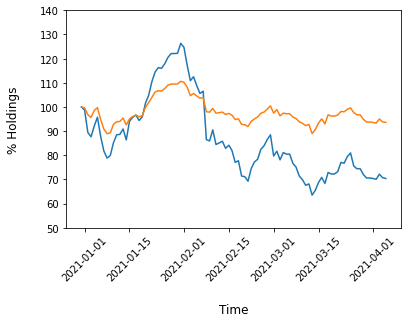

In [25]:
plt.plot([data.date.tolist()[0]- timedelta(days=1),] + data.date.tolist(), [100*x for x in returns_without_adj])
plt.plot([data.date.tolist()[0]- timedelta(days=1),] + data.date.tolist(), [100*x for x in returns_with_adj])
plt.xticks(rotation = 45)
plt.ylim(bottom = 50, top = 140)
plt.ylabel("% Holdings", labelpad = 20, fontsize = 12)
plt.xlabel("Time", labelpad = 20, fontsize = 12)
plt.show()

## With Sentiments

In [26]:
feature_lags = {"Adj_Close_BTC-USD" : 2, 
                "Volume_BTC-USD" : 1, 
                "Adj_Close_SPY" : 1,
                "Adj_Close_GLD" : 1,
                "Adj_Close_CHFUSD=X" : 1,
                "Adj_Close_CNYUSD=X" : 1,
                "Adj_Close_EURUSD=X" : 1,
                "Adj_Close_GBPUSD=X" : 1,
                "Adj_Close_JPYUSD=X" : 1,
                "blockchain_transactions_per_block" : 1,
                "blockchain_hash_rates" : 1,
                "coindesk_sentiment" : 1,
                "num_of_coindesk_posts" : 1,
                "reddit_comments_sentiments" : 1,
                "top_50_reddit_posts_sentiments" : 1}

data = lag(features, feature_lags)
# data['date'] = data['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
# data["date"] = pd.to_datetime(data["date"], format='%d/%m/%Y', infer_datetime_format=True)

data = data[data["date"] >= "1/1/2021"]

train = data[data["date"] <= "2021-03-10"]
test = data[(data["date"] > "2021-03-10") & (data["date"] <= "2021-04-5")]

x_train = train.drop(["date", "Adj_Close_BTC-USD"], axis = 1)
y_train = train["Adj_Close_BTC-USD"]

x_test = test.drop(["date", "Adj_Close_BTC-USD"], axis = 1)
y_test = test["Adj_Close_BTC-USD"]

sc = MinMaxScaler(feature_range = (0, 1))
sc.fit(x_train)
x_train_trans = sc.transform(x_train)
x_test_trans = sc.transform(x_test)

x_train_trans = x_train_trans.reshape(x_train_trans.shape[0], x_train_trans.shape[1], 1)
x_test_trans = x_test_trans.reshape(x_test_trans.shape[0], x_test_trans.shape[1], 1)

In [27]:
res2 = []
# 1 layer
for unit in (4,8,16,32):
    for time_step in (1,2,3,4,5):
        res2.append((([unit],time_step),LSTM_GS([unit], time_step)))

# 2 layers
for unit in (8,16,32):
    for time_step in (1,2,3,4,5):
        res2.append((([unit, unit//2],time_step),LSTM_GS([unit, unit//2], time_step)))

# 3 layers
for unit in (8,16,32):
    for time_step in (1,2,3,4,5):
        res2.append((([unit, unit//2, unit//4],time_step),LSTM_GS([unit, unit//2, unit//4], time_step)))

In [28]:
sorted(res2, key = lambda x : x[1][1])[0]

(([32], 4), (2872.0535416330836, 1963.2683126904924))

In [29]:
layer_config2 = sorted(res2, key = lambda x : x[1])[0][0][0]
time_config2 = sorted(res2, key = lambda x : x[1])[0][0][1]

In [31]:
model2 = LSTM_pipe(layer_config2, time_config2)

In [32]:
# predicted value
yhat2 = model2.predict(x_refit_trans, verbose=0)

In [33]:
for b in [x[0] for x in yhat2]:
    print(b)

28833.53
28769.393
30361.498
31543.918
31188.24
32023.021
34077.438
36790.555
38142.055
37891.78
37144.8
35683.258
33419.734
34480.105
36049.645
35183.26
34046.93
33607.742
33759.35
34259.93
34772.31
32775.266
32237.459
32010.56
31847.451
32245.062
32252.332
30471.062
30917.588
32204.076
32119.732
31433.918
32164.947
33504.605
34927.28
35675.637
36060.676
37144.82
37221.863
41699.797
44118.945
43373.008
44385.08
45277.582
44802.44
45595.26
45793.84
46105.992
48201.49
48168.016
50684.938
52438.555
53102.875
52089.176
48003.285
46283.297
43664.016
47254.28
41479.65
40994.406
44122.766
44454.33
44652.3
43556.58
43761.684
43619.46
45076.492
46195.984
48866.89
51086.875
53100.04
53584.39
56348.125
55929.688
53715.793
52851.984
54746.367
54064.92
53753.156
53939.574
53454.953
51723.688
50383.11
49192.36
48023.145
50182.695
51761.65
52061.44
53258.047
54292.78
55243.99
55926.117
56122.805
55099.39
54995.207


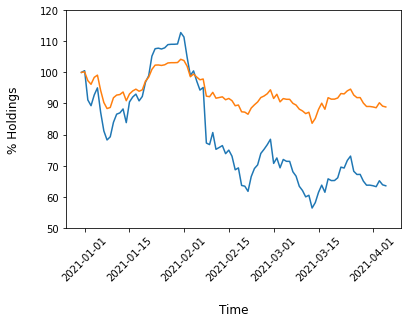

In [36]:
returns_without_adj2 = backtest_regression_noSentiment([x[0] for x in yhat2], 
                                                      data.date.tolist(), 
                                                      "LSTM_regression_no_sentiment")
returns_with_adj2 = backtest_regression_WithSentiment([x[0] for x in yhat2], 
                                  data.date.tolist(), 
                                  sentiments, "LSTM_regression_with_sentiment")

plt.plot([data.date.tolist()[0]- timedelta(days=1),] + data.date.tolist(), [100*x for x in returns_without_adj2])
plt.plot([data.date.tolist()[0]- timedelta(days=1),] + data.date.tolist(), [100*x for x in returns_with_adj2])
plt.xticks(rotation = 45)
plt.ylim(bottom = 50, top = 120)
plt.ylabel("% Holdings", labelpad = 20, fontsize = 12)
plt.xlabel("Time", labelpad = 20, fontsize = 12)
plt.show()